In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torchvision import utils as vutils
import matplotlib.pyplot as plt
import os

Loaded 1200 samples.
Descriptions: ("A silver car with a sleek shape and medium size.'", "A white car with a sleek shape and medium size.'", "A white car with a sleek shape and large size.'")


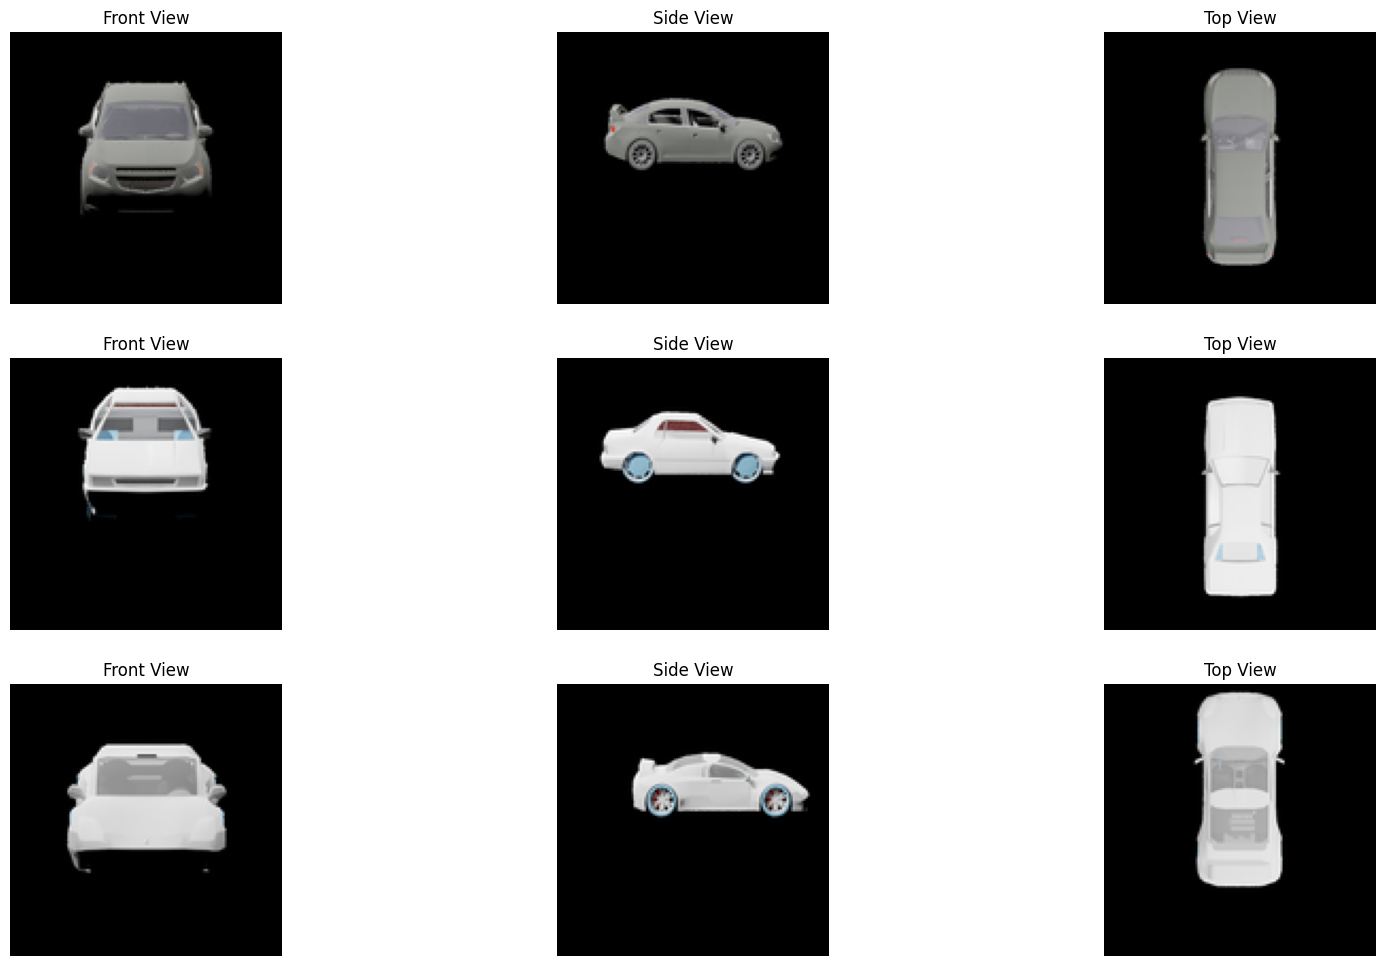

In [5]:
# Paths
ANNOTATION_FILE = "/content/drive/My Drive/CODE/description.txt"  # Update this path
IMAGE_DIR = "/content/drive/My Drive/CODE/rendered_images"        # Update this path

# Define image transforms with reduced resolution
image_transforms = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.LANCZOS),  # Reduce resolution to 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Dataset class with horizontal stretching and different zooming per view
class MultiViewDataset(Dataset):
    def __init__(self, descriptions, image_paths, transform=None, stretch_factor=1.6, zoom_factors=None):
        """
        Args:
            stretch_factor: Controls how much the image is stretched horizontally.
            zoom_factors: A dictionary specifying zoom factors for each view.
        """
        self.descriptions = descriptions
        self.image_paths = image_paths
        self.transform = transform
        self.stretch_factor = stretch_factor
        # Default zoom factors for front, side, and top if not provided
        self.zoom_factors = zoom_factors

    def stretch_zoom_crop(self, img, zoom_factor):
        """
        Stretch the image horizontally, zoom into the center, and crop.
        """
        # Stretch the image horizontally
        width, height = img.size
        new_width = int(width * self.stretch_factor)
        stretched_img = img.resize((new_width, height), Image.LANCZOS)

        # Apply zoom by cropping the center
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)

        left = (stretched_img.width - new_width) // 2
        top = (stretched_img.height - new_height) // 2
        right = left + new_width
        bottom = top + new_height

        # Crop the zoomed-in portion
        return stretched_img.crop((left, top, right, bottom))

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        front, side, top = self.image_paths[idx]

        # Open images
        front_img = Image.open(front).convert("RGB")
        side_img = Image.open(side).convert("RGB")
        top_img = Image.open(top).convert("RGB")

        # Apply stretching and zooming with specific zoom factors for each view
        front_img = self.stretch_zoom_crop(front_img, self.zoom_factors["front"])
        side_img = self.stretch_zoom_crop(side_img, self.zoom_factors["side"])
        top_img = self.stretch_zoom_crop(top_img, self.zoom_factors["top"])

        # Apply transformations
        if self.transform:
            front_img = self.transform(front_img)
            side_img = self.transform(side_img)
            top_img = self.transform(top_img)

        return description, (front_img, side_img, top_img)

# Helper function to load annotations
def load_annotations(file_path, max_samples=1200):
    descriptions = []
    images = []
    missing_folders = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_samples:
                break
            parts = line.strip().split(", Description: ")
            model_id, description = parts[0], parts[1]

            # Remove quotes from model_id
            model_id = model_id.strip("'\"")

            # Folder path for images
            model_folder = os.path.join(IMAGE_DIR, model_id)

            # Paths to images
            front_img = os.path.join(model_folder, "front.png")
            side_img = os.path.join(model_folder, "side.png")
            top_img = os.path.join(model_folder, "top.png")

            # Check for missing data
            if not os.path.exists(model_folder):
                print(f"Missing folder: {model_folder}")
                missing_folders.append(model_id)
                continue
            if not (os.path.exists(front_img) and os.path.exists(side_img) and os.path.exists(top_img)):
                print(f"Missing images in folder: {model_folder}")
                missing_folders.append(model_id)
                continue

            descriptions.append(description)
            images.append((front_img, side_img, top_img))

    if missing_folders:
        print(f"Warning: Missing folders or files for models: {missing_folders}")

    print(f"Loaded {len(descriptions)} samples.")
    return descriptions, images

# Define specific zoom factors for each view
zoom_factors = {"front": 0.35, "side": 0.6, "top": 0.6}

# Load dataset with stretching and different zoom factors
descriptions, image_paths = load_annotations(ANNOTATION_FILE, max_samples=1200)
dataset = MultiViewDataset(descriptions, image_paths, transform=image_transforms, stretch_factor=1.6, zoom_factors=zoom_factors)

# Reload DataLoader with updated dataset
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Visualization function
def visualize_batch(data_loader):
    batch = next(iter(data_loader))
    descriptions, images = batch
    front, side, top = images
    print("Descriptions:", descriptions[:3])  # Print first 3 descriptions
    plt.figure(figsize=(20, 12))  # Adjust figure size
    for i in range(3):  # Visualize first 3 samples
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(front[i].permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize
        plt.title(f"Front View")
        plt.axis("off")
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(side[i].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Side View")
        plt.axis("off")
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(top[i].permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Top View")
        plt.axis("off")
    plt.show()

# Visualize a batch to verify the stretching and zooming effect
visualize_batch(dataloader)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Initialize the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Ensure the model is in evaluation mode
bert_model.eval()

def get_text_embeddings(descriptions, max_length=50):
    """
    Convert a list of text descriptions into embeddings using BERT.
    Args:
        descriptions (list of str): List of descriptions to convert to embeddings.
        max_length (int): Maximum length of the tokenized description.
    Returns:
        torch.Tensor: BERT-generated embeddings for the descriptions.
    """
    embeddings = []
    for description in descriptions:
        inputs = tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)  # Average pooling to get a fixed-size vector
        embeddings.append(embedding)

    return torch.stack(embeddings)


text_embeddings = get_text_embeddings(descriptions).to(device)
print(f"Text Embeddings Shape: {text_embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Text Embeddings Shape: torch.Size([1200, 1, 768])


In [8]:
# Flatten text embeddings to match the expected shape (batch_size, text_embedding_dim)
text_embeddings = text_embeddings.squeeze(1)  # This will remove the second dimension of size 1
print(f"Updated Text Embeddings Shape: {text_embeddings.shape}")

Updated Text Embeddings Shape: torch.Size([1200, 768])


In [16]:
# Tweaked Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.scale = nn.Parameter(torch.ones(1))  # Learnable scaling factor

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        attention = torch.bmm(query, key)
        attention = torch.softmax(attention / self.scale, dim=-1)
        value = self.value(x).view(batch_size, -1, height * width)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        return self.gamma * out + x

# Generator with Residual Connections
class Generator(nn.Module):
    def __init__(self, text_embedding_dim, image_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(text_embedding_dim + 128, 512 * (image_size // 16) * (image_size // 16))
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SelfAttention(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SelfAttention(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, text_embeddings, noise):
        x = torch.cat((text_embeddings, noise), dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 8, 8)
        x = self.upsample(x)
        return x


# Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SelfAttention(128),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            SelfAttention(256),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(512 * 8 * 8, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [17]:
# Load BERT for text embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()
def get_text_embeddings(descriptions, max_length=50):
    embeddings = []
    for description in descriptions:
        inputs = tokenizer(description, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(embedding)
    return torch.cat(embeddings, dim=0)

In [18]:
# Initialize models for Front, Side, and Top views
generator_front = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_side = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_top = Generator(text_embedding_dim=768, image_size=128).to(device)

discriminator_front = Discriminator().to(device)
discriminator_side = Discriminator().to(device)
discriminator_top = Discriminator().to(device)

# Optimizers
optimizer_G_front = optim.Adam(generator_front.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G_side = optim.Adam(generator_side.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G_top = optim.Adam(generator_top.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer_D_front = optim.Adam(discriminator_front.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_D_side = optim.Adam(discriminator_side.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_D_top = optim.Adam(discriminator_top.parameters(), lr=0.0004, betas=(0.5, 0.999))


In [19]:
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [20]:
text_embeddings = text_embeddings.squeeze(1)

In [224]:
# Front View
generator_front = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_front.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_front_epoch_125.pth"))
generator_front.eval()
print("Model loaded successfully!")

<ipython-input-224-48bb89f6f8ad>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_front.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkp

Model loaded successfully!


In [473]:
# Side View
generator_side = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_side.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_side_epoch_125.pth"))
generator_side.eval()
print("Model loaded successfully!")

<ipython-input-473-093c6f369cc7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_side.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkpo

Model loaded successfully!


In [117]:
# Top View
generator_top = Generator(text_embedding_dim=768, image_size=128).to(device)
generator_top.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkpoints/1/generator_top_epoch_125.pth"))
generator_top.eval()
print("Model loaded successfully!")

<ipython-input-117-dee629a1120e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_top.load_state_dict(torch.load("/content/drive/MyDrive/CODE/saved_models/checkpoi

Model loaded successfully!


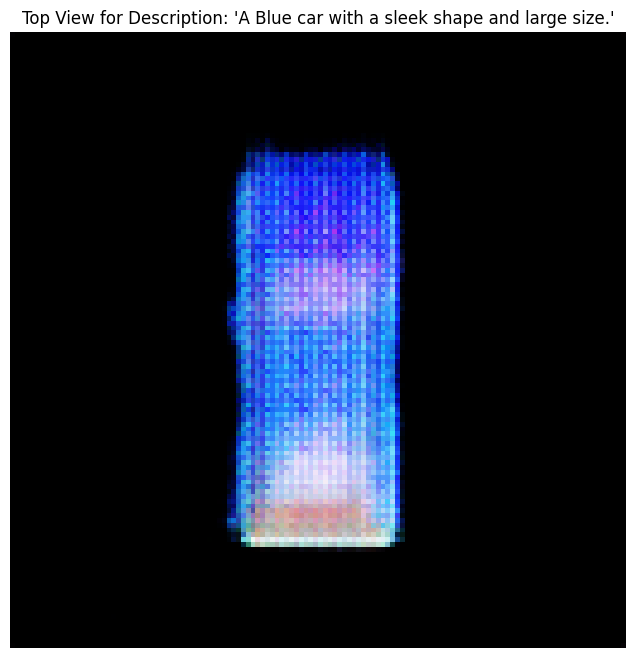

In [63]:
# Generate Top View Image
def generate_top_view(description):
    """
    Generate the top view image from a text description using the pre-trained generator model.
    """
    text_embeddings = get_text_embeddings([description])
    noise = torch.randn(text_embeddings.shape[0], 128).to(device)

    with torch.no_grad():
        fake_top = generator_top(text_embeddings, noise)
    fake_top = fake_top * 0.5 + 0.5  # Denormalize to [0, 1]

    # Visualize Top View Image
    grid = vutils.make_grid(fake_top[:1], nrow=1, normalize=True, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f"Top View for Description: '{description}'")
    plt.axis("off")
    plt.show()

# Description
description = "A Blue car with a sleek shape and large size."
generate_top_view(description)


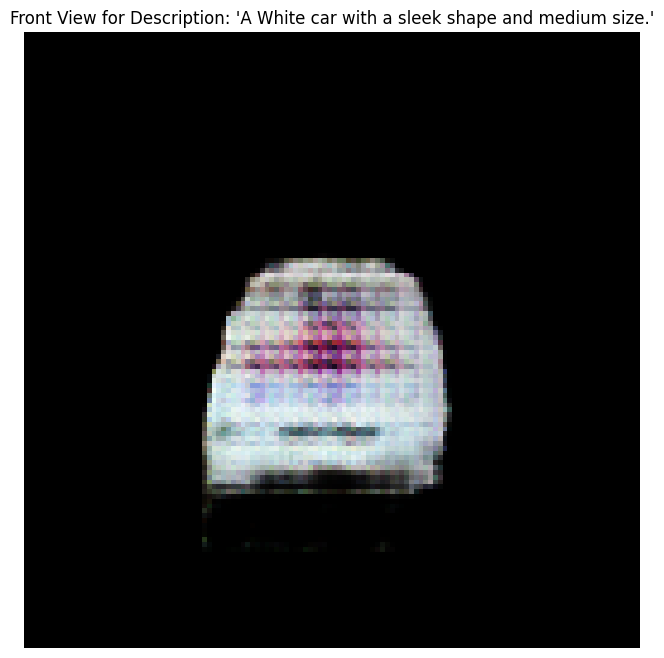

In [299]:
# Generate Front View Image
def generate_front_view(description):
    """
    Generate the front view image from a text description using the pre-trained generator model.
    """
    text_embeddings = get_text_embeddings([description])
    noise = torch.randn(text_embeddings.shape[0], 128).to(device)

    with torch.no_grad():
        fake_front = generator_front(text_embeddings, noise)
    fake_front = fake_front * 0.5 + 0.5  # Denormalize to [0, 1]

    # Visualize Front View Image
    grid = vutils.make_grid(fake_front[:1], nrow=1, normalize=True, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f"Front View for Description: '{description}'")
    plt.axis("off")
    plt.show()

# Description
description = "A White car with a sleek shape and medium size."
generate_front_view(description)


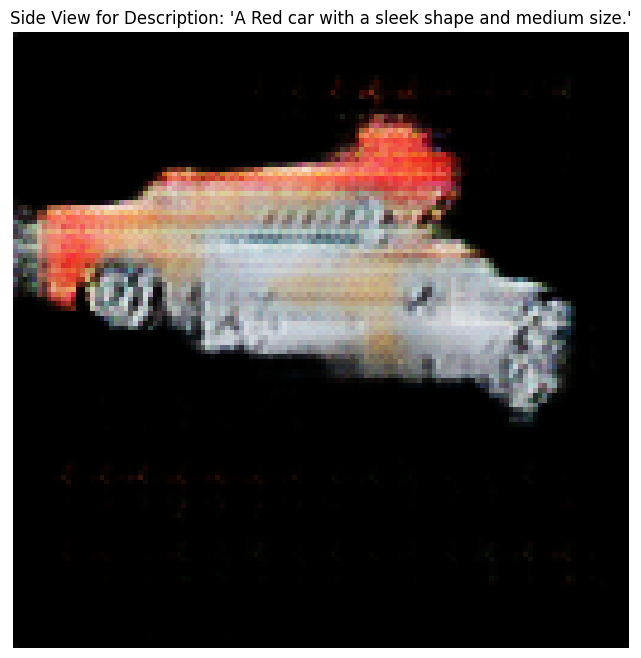

In [497]:
# Generate Side View Image
def generate_side_view(description):
    """
    Generate the side view image from a text description using the pre-trained generator model.
    """
    text_embeddings = get_text_embeddings([description])
    noise = torch.randn(text_embeddings.shape[0], 128).to(device)

    with torch.no_grad():
        fake_side = generator_side(text_embeddings, noise)
    fake_side = fake_side * 0.5 + 0.5  # Denormalize to [0, 1]

    # Visualize Side View Image
    grid = vutils.make_grid(fake_side[:1], nrow=1, normalize=True, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f"Side View for Description: '{description}'")
    plt.axis("off")
    plt.show()

# Description
description = "A Red car with a sleek shape and medium size."
generate_side_view(description)


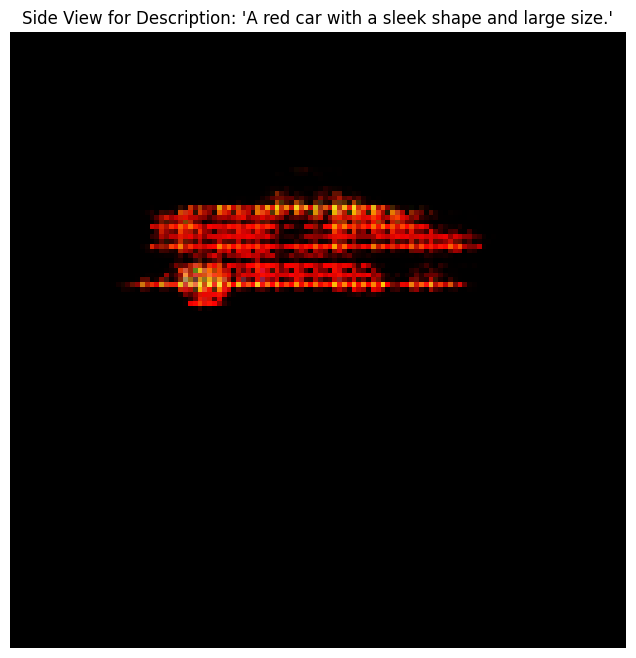

In [430]:
# Generate Side View Image
def generate_side_view(description):
    """
    Generate the side view image from a text description using the pre-trained generator model.
    """
    text_embeddings = get_text_embeddings([description])
    noise = torch.randn(text_embeddings.shape[0], 128).to(device)

    with torch.no_grad():
        fake_side = generator_side(text_embeddings, noise)
    fake_side = fake_side * 0.5 + 0.5  # Denormalize to [0, 1]

    # Visualize Side View Image
    grid = vutils.make_grid(fake_side[:1], nrow=1, normalize=True, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f"Side View for Description: '{description}'")
    plt.axis("off")
    plt.show()

# Description
description = "A red car with a sleek shape and large size."
generate_side_view(description)
